In [1]:
import pandas as pd
import numpy as np 
import binascii # Binary to Ascii 
from pathlib import Path
from datetime import datetime
import pickle
import io
import glob
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

## Setup lab structure

In [2]:
fields = ["start-time",	"uid", "src_ip", "src_port", "dst_ip", "dst_port", "proto",	"service", "duration", "orig_bytes", "resp_bytes", "conn_state", "local_orig", "local_resp", "missed_bytes", "history",	"orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "tunnel_parents"]
malicious_ips = ['192.168.70.137', '64.227.69.82', '104.248.193.232'] #  '137.184.96.176' is actually a target, but anything going to it is malicious
internal_range = ['192.168.70.4', '192.168.70.160', '192.168.70.222', '192.168.70.203', '192.168.70.107', '192.168.70.101', '192.168.70.20']

## Read in data

In [ ]:
packetdata = glob.glob("packetcsvs/*")
cols = ['time','src_ip', 'dst_ip', 'proto', 'ttl', 'flags','src_port', 'dst_port', 'payload']
packets = pd.DataFrame()
for p in packetdata:
    print(p)
    packets = pd.concat([packets, pd.read_csv(p, names=cols)])
    
packets.to_pickle('packets.pickle')

packetcsvs/jul26webattacks.csv
packetcsvs/jul28attacksclean.csv
packetcsvs/jul27dnsattacksclean.csv
packetcsvs/aug1attacksclean.csv
packetcsvs/jul14.csv
packetcsvs/aug5attacksclean.csv
packetcsvs/aug3.csv
packetcsvs/jul25attacks.csv
packetcsvs/aug9.csv
packetcsvs/jul18.csv


In [4]:
packets

,time,src_ip,dst_ip,proto,ttl,flags,src_port,dst_port,payload
0,2022-07-26 08:28:48.319307 -0600 MDT,192.168.70.203,104.86.252.109,TCP,128,,51485,80,NaN
1,2022-07-26 08:28:48.349063 -0600 MDT,104.86.252.109,192.168.70.203,TCP,57,,80,51485,NaN
2,2022-07-26 08:28:48.370941 -0600 MDT,192.168.70.203,104.86.252.109,TCP,128,,51485,80,NaN
3,2022-07-26 08:28:48.763006 -0600 MDT,192.168.70.169,192.168.70.3,TCP,64,,45690,8006,"�s��<M|��|f�]�����+ �o���R����;�f,�+.Ŵ���..."
4,2022-07-26 08:28:48.77064 -0600 MDT,192.168.70.3,192.168.70.169,TCP,64,,8006,45690,"R5��a����~����k]0��#��1�!H-.~\r��""�,�َ�lw..."
...,...,...,...,...,...,...,...,...,...
13326,2022-08-09 14:55:38.829104 -0600 MDT,137.184.96.176,45.61.188.18,,64,,5188,55825,NaN
13327,2022-08-09 14:55:48.21098 -0600 MDT,43.131.91.178,137.184.96.176,,49,,24217,2548,NaN
13328,2022-08-09 14:55:48.211008 -0600 MDT,137.184.96.176,43.131.91.178,,64,,2548,24217,NaN
13329,2022-08-09 14:55:52.670953 -0600 MDT,172.104.211.178,137.184.96.176,,246,NaN,61000,448,NaN


## Convert zeek data to CSV format

In [5]:
def zeekToCsv(conlog: str, fieldz: list):
    outcsv = 'ztemp.csv'
    with open(conlog) as file:
        lines = file.read().splitlines()
        with open(outcsv,"w") as outfile:
            for line in lines:
                if line[0] == '#':
                    continue
                line = ",".join(line.split())
                outfile.write(line + '\n')       

In [6]:
logs = glob.glob('zeeklogs/*/conn.log')
metadata = pd.DataFrame()
for log in logs:
    print(log)
    zeekToCsv(log, fields)
    metadata = pd.concat([metadata, pd.read_csv("ztemp.csv", names=fields)])

zeeklogs/jul27/conn.log
zeeklogs/jul26/conn.log
zeeklogs/jul18/conn.log


/projects/skynet/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (14,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


zeeklogs/aug9/conn.log
zeeklogs/aug1/conn.log
zeeklogs/aug6/conn.log
zeeklogs/aug3/conn.log
zeeklogs/jul25/conn.log
zeeklogs/jul14/conn.log
zeeklogs/jul28/conn.log


## Fix start and end time in metadata

In [7]:
metadata = metadata[~(metadata['duration'].isin(['ntlm', 'smb', 'gssapi', '-', 'dce_rpc']))]
end_time = metadata['start-time'] + metadata['duration'].astype(float)
metadata['end-time'] = end_time
metadata['end-time'] = pd.to_datetime(metadata['end-time'], unit='s')
metadata['start-time'] = pd.to_datetime(metadata['start-time'],unit='s')

## Determine service type and add it to metadata

In [8]:
metadata.loc[(metadata['proto'] == 'udp') & (metadata['dst_port'] == 443), 'service'] = 'quic'
metadata.loc[(metadata['proto'] == 'udp') & (metadata['dst_port'] == 123), 'service'] = 'ntp'
metadata.loc[(metadata['dst_port'] == 138), 'service'] = 'netbios'
metadata.loc[(metadata['dst_port'] == 139), 'service'] = 'netbios'
metadata.loc[(metadata['dst_port'] == 445), 'service'] = 'smb'
metadata.loc[(metadata['dst_port'] == 143), 'service'] = 'imap'
metadata.loc[(metadata['proto'] == 'tcp') & (metadata['dst_port'] == 80), 'service'] = 'http'
metadata.loc[(metadata['proto'] == 'tcp') & (metadata['dst_port'] == 22), 'service'] = 'ssh'
metadata.loc[(metadata['proto'] == 'tcp') & (metadata['dst_port'] == 88), 'service'] = 'kerberos5'
metadata.loc[(metadata['proto'] == 'tcp') & (metadata['dst_port'] == 389), 'service'] = 'ldap'
metadata.loc[(metadata['proto'] == 'tcp') & (metadata['dst_port'] == 465), 'service'] = 'smtp'

<AxesSubplot:ylabel='service'>

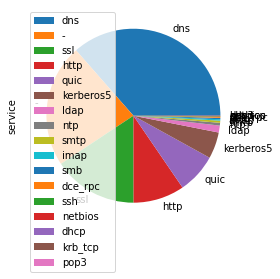

In [9]:
metadata['service'].value_counts().plot(kind='pie', legend='service')

## Label each malicious flow with correct traffic type

In [10]:
malicious = metadata[(metadata['src_ip'].isin(malicious_ips)) | (metadata['dst_ip'].isin(malicious_ips))]
malicious = malicious[malicious['src_ip'].isin(internal_range) | malicious['dst_ip'].isin(internal_range)]

malicious['label'] = "MALICIOUS"
malicious['detailed-label'] = "MALICIOUS"

In [11]:
bt = datetime.strptime('2022-08-09 09:14:28', '%Y-%m-%d %H:%M:%S')
et1 = datetime.strptime('2022-08-03 10:27:40', '%Y-%m-%d %H:%M:%S')
et2 = datetime.strptime('2022-08-03 18:27:38', '%Y-%m-%d %H:%M:%S')

In [13]:
malicious = malicious.reset_index(drop=True)
tunneluids = pickle.load(open('dnstunneluids', 'rb'))
for ind, row in malicious.iterrows():
    if row['uid'] in (tunneluids):
        malicious.at[ind, 'detailed-label'] = 'dns-tunnel-c2'
    
    elif ((row['src_ip'] == '192.168.70.137') or (row['dst_ip'] == '192.168.70.137')) and (row['start-time'] > bt):
        malicious.at[ind,'detailed-label'] = 'CredentialAttack'
        
    elif (row['src_ip'] == '192.168.70.137') and (row['dst_port'] == 80) and (row['dst_ip'] == '192.168.70.101'):
        malicious.at[ind,'detailed-label'] = 'WebAttack'
        
    elif (row['src_ip'] == '192.168.70.215') and (row['dst_port'] == 80) and (row['dst_ip'] == '192.168.70.203'): 
        malicious.at[ind,'detailed-label'] = 'WebAttack' #.215 was used by some of the interns for webattacks
        
    elif (row['src_ip'] == '192.168.70.137') and (row['dst_port'] == 80) and (row['dst_ip'] == '192.168.70.203'):
        malicious.at[ind,'detailed-label'] = 'WebAttack'
    
    elif row['dst_ip'] == '104.248.193.232':
        malicious.at[ind,'detailed-label'] = 'C2'
    
    elif row['dst_ip'] == '64.227.69.82':
        malicious.at[ind,'detailed-label'] = 'C2'
        
    elif (row['start-time'] >= et1) and (row['end-time'] <= et2) and (row['src_ip'] == '192.168.70.137'):
        malicious.at[ind,'detailed-label'] = 'ExploitAttempt'
        
    elif row['src_ip'] == '192.168.70.137':
        malicious.at[ind,'detailed-label'] = 'PortScanorEnumeration' # actually this may not be the only category
    
    elif row['dst_ip'] == '192.168.70.137':
        malicious.at[ind,'detailed-label'] = 'PortScanorEnumeration'
        
    else:
        continue #theres a ping from the c2 server to the DC. not sure how to label it.
        #print(row)

malicious['detailed-label'].value_counts()

ExploitAttempt           3325
PortScanorEnumeration    2652
CredentialAttack         2332
C2                       1587
WebAttack                 971
dns-tunnel-c2              33
MALICIOUS                   1
Name: detailed-label, dtype: int64

## Display service types of malicious traffic

<AxesSubplot:ylabel='service'>

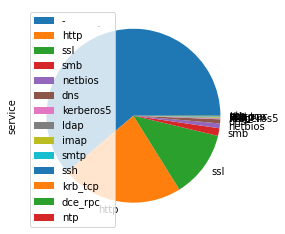

In [14]:
pd.set_option('display.max_rows', 20)
malicious['service'].value_counts().plot(kind='pie', legend='service')

## Label each benign flow with correct traffic type

In [15]:
benign = metadata[~((metadata['src_ip'].isin(malicious_ips)) | (metadata['dst_ip'].isin(malicious_ips)))]
benign['label'] = "BENIGN"
benign['detailed-label'] = "BENIGN"

benign.loc[benign['dst_ip'] != '137.184.96.176', 'label'] = 'MALICIOUS'
benign.loc[benign['dst_ip'] == '137.184.96.176', 'label'] = 'MALICIOUS'
benign.loc[(benign['dst_ip'] == '137.184.96.176') & (benign['dst_port'] == 22), 'detailed-label'] = 'CredentialAttack'
benign.loc[(benign['dst_ip'] == '137.184.96.176') & (benign['dst_port'] != 22), 'detailed-label'] = 'PortScan'

<ipython-input-15-f229a98ee507>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benign['label'] = "BENIGN"
<ipython-input-15-f229a98ee507>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benign['detailed-label'] = "BENIGN"
/projects/skynet/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

## Combine malicious and benign data and save to flows.csv

In [20]:
metadata = pd.concat([malicious, benign])
metadata.to_csv('flows.csv')
metadata['detailed-label'].value_counts()

BENIGN                   330260
ExploitAttempt             3325
PortScanorEnumeration      2652
CredentialAttack           2615
PortScan                   2040
C2                         1587
WebAttack                   971
dns-tunnel-c2                33
MALICIOUS                     1
Name: detailed-label, dtype: int64

In [21]:
metadata

,start-time,uid,src_ip,src_port,dst_ip,dst_port,proto,service,duration,orig_bytes,...,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,end-time,label,detailed-label
0,2022-07-27 19:08:10.964237056,CbCzGz1RY3GV1QMAIf,192.168.70.101,49016,104.248.193.232,8000,tcp,http,1.436578,143,...,1042160,ShADadgggfF,306,16063,487,1067697,-,2022-07-27 19:08:12.400815104,MALICIOUS,C2
1,2022-07-27 19:14:29.476582144,CsWIuqzZhaEodz2Yh,192.168.70.101,41686,104.248.193.232,4444,tcp,-,2547.486481,25453,...,10720,ShAdDaGfFr,89,30089,154,17803,-,2022-07-27 19:56:56.963063040,MALICIOUS,C2
2,2022-07-27 15:53:44.726011136,CZxFgyRusvSEn2XQi,192.168.70.203,56081,104.248.193.232,8888,tcp,-,28765.818459,536364,...,0,DadATTT,1949,614978,2596,268921,-,2022-07-27 23:53:10.544470016,MALICIOUS,C2
3,2022-07-26 14:32:31.599229184,CcyUlY1m4cauoEpoI7,192.168.70.137,48804,192.168.70.101,80,tcp,http,0.017943,0,...,0,^cCd,0,0,1,3959,-,2022-07-26 14:32:31.617171968,MALICIOUS,WebAttack
4,2022-07-26 14:34:51.235289088,CDBT4E2cWrzBXk3am,192.168.70.137,48810,192.168.70.101,80,tcp,http,0.012469,0,...,0,^cCd,0,0,1,1796,-,2022-07-26 14:34:51.247758080,MALICIOUS,WebAttack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64851,2022-07-28 17:26:47.197274880,CEL4sk2AeBYSGLHOx5,192.168.70.203,55061,40.83.247.108,443,tcp,ssl,20283.989408,37613,...,5004,ShADdgaGtT,704,66383,367,79894,-,2022-07-28 23:04:51.186682880,MALICIOUS,BENIGN
64853,2022-07-28 17:02:24.705147136,CDnnla11ClwzRVvGL1,192.168.70.160,61533,52.23.44.129,443,tcp,ssl,21764.854165,1055050,...,1059129,ShADdgaGGGTtT,581,1094398,1141,341424,-,2022-07-28 23:05:09.559312128,MALICIOUS,BENIGN
64854,2022-07-28 23:04:58.912038144,C7Y5JsMWqbKFXVGG6,192.168.70.203,57516,142.251.33.74,443,udp,quic,0.097980,3268,...,0,Dd,6,936,6,1261,-,2022-07-28 23:04:59.010018048,MALICIOUS,BENIGN
64855,2022-07-28 15:47:56.462727168,CMsEMm4WJLUxLuvDX5,192.168.70.101,46488,170.114.14.67,443,tcp,-,26233.618017,6825,...,0,DdATta,394,27407,201,16583,-,2022-07-28 23:05:10.080743936,MALICIOUS,BENIGN


## Assign packets to Flows

In [22]:
def PacketsToFlows(packetdf, meta_data):
    flows = {}
    for idx in tqdm(range(len(meta_data))):
        delta = timedelta(milliseconds=1)
        flow = packetdf[(packetdf['time'] >= meta_data['start-time'][idx] - delta) & (packetdf['time'] - delta <= meta_data['end-time'][idx]) & (packetdf['src_ip'] == meta_data['src_ip'][idx]) & (packetdf['dst_ip'] == meta_data['dst_ip'][idx]) & (packetdf['src_port'] == meta_data['src_port'][idx]) & (packetdf['dst_port'] == meta_data['dst_port'][idx])]
        flow2 = packetdf[(packetdf['time'] >= meta_data['start-time'][idx] - delta) & (packetdf['time'] - delta <= meta_data['end-time'][idx]) & (packetdf['dst_ip'] == meta_data['src_ip'][idx]) & (packetdf['src_ip'] == meta_data['dst_ip'][idx]) & (packetdf['drc_port'] == meta_data['src_port'][idx]) & (packetdf['src_port'] == meta_data['dst_port'][idx])]
        flow = pd.concat([flow, flow2])
        flow = flow.sort_values('time')

        flows[idx] = flow
    print("Processed ", len(flows), "flows")
    return flows

In [ ]:
packets['time'] = pd.to_datetime(packets['time'], infer_datetime_format=True)
flows = PacketsToFlows(packets, metadata)